# Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Statistical Analysis notebook

In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

from numpy.random import seed
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import pearsonr
from scipy.stats import norm

from scipy.spatial.distance import euclidean
import scipy.stats as st

In [2]:
#load data saved in data wrangling notebook
y=pickle.load(open("y_s.p","rb"))
X=pickle.load(open("X_s.p","rb"))

In [3]:
#first sort the positive and negative slides into lists. 
X_p,X_n=[],[]
for idx,row in y.iterrows():
    if row.label==1:
        X_p.append(X.get(row.id))       
    else:
        X_n.append(X.get(row.id))

Recall that the cropped images seemed substantially the same as the full images, so we can use the cropped to reduce the size of the computational task by 8/9ths if they are close enough. So first we will confirm how closely they are correlated


In [4]:
#crop
X_p_c=[a[31:63,31:63] for a in X_p]
X_n_c=[a[31:63,31:63] for a in X_n]

#also flatten into 1d
X_p_v=[a.flatten() for a in X_p_c]
X_n_v=[a.flatten() for a in X_n_c]

In [5]:
#we'll look at correlations for each of the three color channels
#X_n_c_s=X_n_c[:len(X_p_c)] #truncating the lists so we have the same number of pos and neg samples
bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p:
    b,g,r=cv2.split(each)
    bp.append(b)
    gp.append(g)
    rp.append(r)
for each in X_n:
    b,g,r=cv2.split(each)
    bn.append(b)
    gn.append(g)
    rn.append(r)
    
#now the cropped samples
bpc,gpc,rpc,bnc,gnc,rnc=[],[],[],[],[],[]
for each in X_p_c:
    b,g,r=cv2.split(each)
    bpc.append(b)
    gpc.append(g)
    rpc.append(r)
for each in X_n_c:
    b,g,r=cv2.split(each)
    bnc.append(b)
    gnc.append(g)
    rnc.append(r)
    
#get mean and variance for comparison
color_channels=[bp,bpc,gp,gpc,rp,rpc,bn,bnc,gn,gnc,rn,rnc]
col_means,col_var=[],[]

for each in color_channels:
    col_means.append([np.mean(a) for a in each])
    col_var.append([np.var(a) for a in each])
    


In [6]:
colors=['Blue','Green','Red']
labels=[' Positive',' Negative']
agg=[' Mean',' Variance']
print('Pearson correlaton between the color channel means')
i=0
for j in colors:
    for k in labels:
        print(j,k,agg[0],pearsonr(col_means[i],col_means[i+1]))
        i+=2
print('Pearson correlaton between the color channel variance')
i=0
for j in colors:
    for k in labels:
        print(j,k,agg[0],pearsonr(col_var[i],col_means[i+1]))
        i+=2

Pearson correlaton between the color channel means
Blue  Positive  Mean (0.9500189905640555, 0.0)
Blue  Negative  Mean (0.9510975491015605, 0.0)
Green  Positive  Mean (0.949360218297266, 0.0)
Green  Negative  Mean (0.9696177966882844, 0.0)
Red  Positive  Mean (0.9685457591190479, 0.0)
Red  Negative  Mean (0.9748282475565806, 0.0)
Pearson correlaton between the color channel variance
Blue  Positive  Mean (-0.4164383384991959, 1.3377723170191442e-166)
Blue  Negative  Mean (0.16952786506398515, 5.074062562800967e-27)
Green  Positive  Mean (-0.4763364231370984, 2.2507546865713404e-224)
Green  Negative  Mean (-0.6334806657304718, 0.0)
Red  Positive  Mean (-0.3739000680475001, 3.279784736004698e-199)
Red  Negative  Mean (-0.6960653733164818, 0.0)


In [6]:
#make grayscale and flatten
X_gr_p,X_gr_n=[],[]
for each in X_p_c:
    X_gr_p.append(cv2.cvtColor(each, cv2.COLOR_BGR2GRAY))
for each in X_n_c:
    X_gr_n.append(cv2.cvtColor(each, cv2.COLOR_BGR2GRAY))
X_gr_p_v=[a.flatten() for a in X_gr_p]
X_gr_n_v=[a.flatten() for a in X_gr_n]


In [7]:
#plot a reminder of what the aggregate data look like

X_p_mean=[np.mean(each) for each in X_p_v]
X_n_mean=[np.mean(each) for each in X_n_v]
X_p_var=[np.var(each) for each in X_p_v]
X_n_var=[np.var(each) for each in X_n_v]
X_p_gr_mean=[np.mean(each) for each in X_gr_p_v]
X_n_gr_mean=[np.mean(each) for each in X_gr_n_v]
X_p_gr_var=[np.var(each) for each in X_gr_p_v]
X_n_gr_var=[np.var(each) for each in X_gr_n_v]

Now that we can see the differences visually, let's quantify them. We'll calculate 


In [8]:
#crop
X_p_c=[a[31:63,31:63] for a in X_p]
X_n_c=[a[31:63,31:63] for a in X_n]

We can see from a visual inspection that there appear to be differences between the positive and negative groups:
* The aggregate data are distributed differently, with a bimodal vs. unimodal distribution in the negative and positive groups, respectively.
* The distributions of the pixel values also differ, with the negative group having many more higher value (greater than about 215) pixels and the positive having a greater preponerance of middling (about 100-200) values. 
* n.b. As the differences in shape of the pixel distributions are similar for all 3 color channels, we will use the grayscale here.


Given these apparent differencs, let's analyze them and see how statistically significant the apparent differences are. We will analyze the following:
* difference between the means distributions
* difference between the grayscale pixel values distributions
* pairwise correlation between the color channels

First, we'll look at whether there is a difference in the correlation of any two color channels between positive and negative groups. We will look at:
* red vs blue
* red vs green
* green vs blue
in both groups

In [9]:
#first split the color channels
X_n_c_s=X_n_c[:len(X_p_c)] #truncating the lists so we have the same number of pos and neg samples
bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p_c:
    b,g,r=cv2.split(each)
    bp.append(b)
    gp.append(g)
    rp.append(r)
for each in X_n_c_s:
    b,g,r=cv2.split(each)
    bn.append(b)
    gn.append(g)
    rn.append(r)
    
#flatten into arrays
bpa=np.array(bp).flatten()
gpa=np.array(gp).flatten()
rpa=np.array(rp).flatten()
bna=np.array(bn).flatten()
gna=np.array(gn).flatten()
rna=np.array(rn).flatten()

In [10]:
#arrange data into dataframes to pass to seaborn
d={'bp':bpa,'gp':gpa,'rp':rpa,'bn':bna,'gn':gna,'rn':rna}
dp={'Blue':bpa,'Green':gpa,'Red':rpa}
dn={'Blue':bna,'Green':gna,'Red':rna}
X_df=pd.DataFrame(data=d)
X_p_df=pd.DataFrame(data=dp)
X_n_df=pd.DataFrame(data=dn)

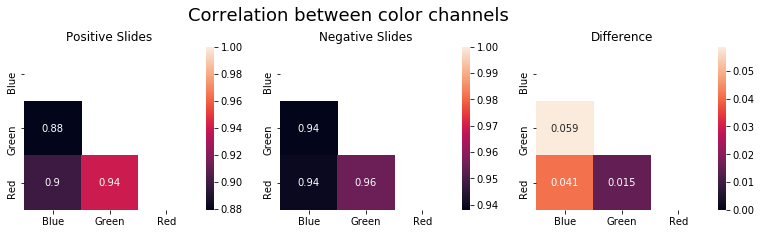

In [11]:
#plot the correlation matrix
fig,axs = plt.subplots(1,3, figsize=(13,3))
fig.text(x=0.3,y=1,s='Correlation between color channels',fontsize=18)
corrp=X_p_df.corr()
corrn=X_n_df.corr()
corrdiff=abs(corrp-corrn)
mask = np.triu(np.ones_like(corrp, dtype=np.bool))
sns.heatmap(corrp,ax=axs[0],mask=mask,annot=True).set_title('Positive Slides')
sns.heatmap(corrn,ax=axs[1],mask=mask,annot=True).set_title('Negative Slides')
sns.heatmap(corrdiff,ax=axs[2],mask=mask,annot=True).set_title('Difference')
plt.show()

The correlation between both the blue/green and blue/red values is a little more significant in the positive than in the negative group. Let's check the p values for the pearson correlations mapped above.

let's now compare the means of the channels and see if there is more correlation there

In [12]:
bp_mean=[np.mean(a) for a in bp]
gp_mean=[np.mean(a) for a in gp]
rp_mean=[np.mean(a) for a in rp]
bn_mean=[np.mean(a) for a in bn]
gn_mean=[np.mean(a) for a in gn]
rn_mean=[np.mean(a) for a in rn]

In [13]:
Xpmeand={'Label':'Positive','Blue':bp_mean,'Green':gp_mean,'Red':rp_mean}
Xnmeand={'Label':'Negative','Blue':bn_mean,'Green':gn_mean,'Red':rn_mean}

X_p_df=pd.DataFrame(Xpmeand)
X_n_df=pd.DataFrame(Xnmeand)

X_mean_df=X_p_df.append(X_n_df)


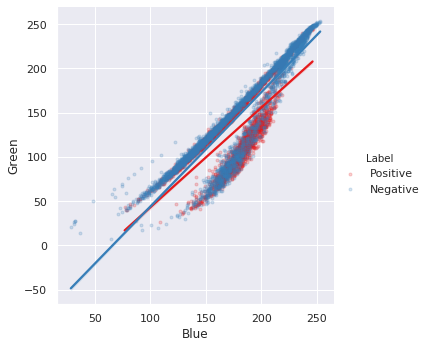

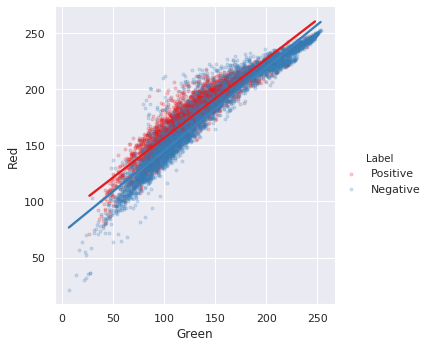

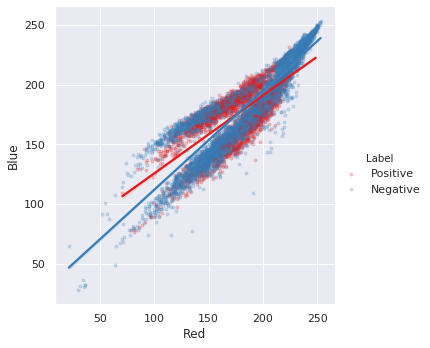

In [14]:
#fig,axs=plt.subplots(3,1, figsize=(7,7))
sns.set()
sns.lmplot(x='Blue',y='Green',data=X_mean_df,hue='Label',palette='Set1',markers='.',scatter_kws={'alpha':0.2},aspect=1)
sns.lmplot(x='Green',y='Red',data=X_mean_df,hue='Label',palette='Set1',markers='.',scatter_kws={'alpha':0.2},aspect=1)
sns.lmplot(x='Red',y='Blue',data=X_mean_df,hue='Label',palette='Set1',markers='.',scatter_kws={'alpha':0.2},aspect=1)
plt.show()

#### Because there appears to be a difference in the correlations between positive and negative sets, let's quantify it by using a correlation matrix.

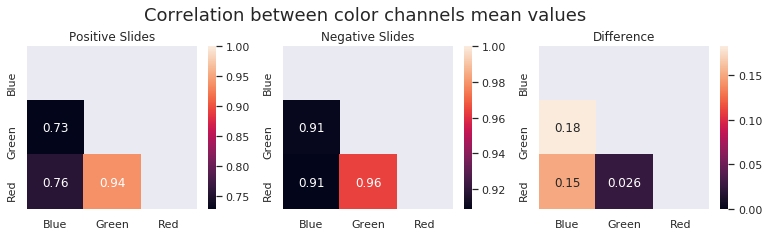

In [15]:
#plot the correlation matrix
fig,axs = plt.subplots(1,3, figsize=(13,3))
fig.text(x=0.25,y=1,s='Correlation between color channels mean values',fontsize=18)
corrp=X_p_df.corr()
corrn=X_n_df.corr()
corrdiff=abs(corrp-corrn)
mask = np.triu(np.ones_like(corrp, dtype=np.bool))
sns.heatmap(corrp,ax=axs[0],mask=mask,annot=True).set_title('Positive Slides')
sns.heatmap(corrn,ax=axs[1],mask=mask,annot=True).set_title('Negative Slides')
sns.heatmap(corrdiff,ax=axs[2],mask=mask,annot=True).set_title('Difference')
plt.show()

#### Again we see that there is a stronger correlation between the blue/red and blue/green channels than the red/green.

In [8]:
#plot the distance
#distance distribution p-p
#distance distribution p-n
pp_dist,pn_dist=[],[]
for i in X_p_v:
    for j in X_p_v:        
        pp_dist.append(euclidean(i,j))
            

In [9]:
for i in X_p_v:
    for j in X_n_v:        
        pn_dist.append(euclidean(i,j))

In [10]:
nn_dist=[]
for i in X_n_v:
    for j in X_n_v:        
        nn_dist.append(euclidean(i,j))

In [ ]:
sns.distplot(pp_dist,hist=False,label='Pos-Pos')
sns.distplot(pn_dist,hist=False,label='Pos-Neg')
sns.distplot(nn_dist,hist=False,label='Neg-Neg')

plt.set_title('Euclidean Distances between slides')
plt.set_xlabel('Euclidean Distance')
plt.set_ylabel('Relative Frequency')
plt.show()

In [11]:
distances=[pp_dist,pn_dist,nn_dist]
d_means=[np.mean(a) for a in distances]
d_ci95=[np.percentile(a,[2.5,97.5]) for a in distances]

for i in range(len(distances)):
    print(d_means[i],d_ci95[i])

8308.857246431498 [6381.81584661 9870.24085952]
8438.373045192357 [ 6732.38004906 10356.97269476]
8182.939296844662 [ 5922.63494992 10796.51637103]


#### Let's also look at the statistical properties of the two groups and see how statistically significant their differences are.

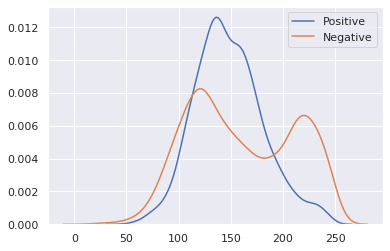

In [16]:
#distribution of the aggregate means first
X_gr_p_m=[np.mean(a) for a in X_gr_p_v]
X_gr_n_m=[np.mean(a) for a in X_gr_n_v]

sns.distplot(X_gr_p_m,hist=False,label='Positive')
sns.distplot(X_gr_n_m,hist=False,label='Negative')
plt.show()

We can see the distributions of the means differ significantly, so let's see if we can model them 

The positive slides are roughtly unimodal so we'll try with a gaussian distribution, and the negative slides are bimodal so we'll try to model it first with the sum of 2 gaussian distributions

#### First we'll try to match with random sample then try to refine the modeling with bayesian analysis

In [17]:
#calculate mean and 95% confidence interval for positives
pos_mean=np.mean(X_gr_p_m)
pos_mean_ci95=np.percentile(X_gr_p_m,[2.5,97.5])
pos_mean_std=np.std(X_gr_p_m)

n_pos=len(X_gr_p_m)
n_neg=len(X_gr_n_m)

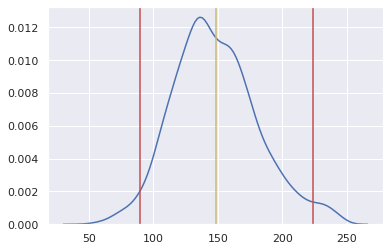

32.96490597402204
148.26581363179073


In [18]:
#look at positives first
_=sns.distplot(X_gr_p_m,hist=False)
_=plt.axvline(pos_mean_ci95[0],color='r')
_=plt.axvline(pos_mean,color='y')
_=plt.axvline(pos_mean_ci95[1],color='r')
plt.show()
print(pos_mean_std)
print(pos_mean)

In [ ]:
#draw a random sample with normal distribution based on the aggregate of the means of the image values
pos_sim=poisson(mu=pos_mean).rvs(n_pos)


In [ ]:
#plot simulated positives agains observed positives
sns.distplot(X_gr_p_m,hist=False,label='Observed')
sns.distplot(pos_sim,hist=False,label='Simulated')
plt.show()

And the same for the negative sample.

In [ ]:
#draw a random sample
neg_sim1=norm(loc=120,scale=22).rvs(n_neg//2)
neg_sim2=norm(loc=220,scale=28).rvs(n_neg//2)
neg_sim=np.append(neg_sim1,neg_sim2)


In [ ]:
#plot simulated negatives agains observed positives
sns.distplot(X_gr_n_m,hist=False,label='Observed')
sns.distplot(neg_sim,hist=False,label='Simulated')
plt.show()

Now that we have a baseline simulation, I would like to see if we can refine. We'll use a Markov chain monte carlo simulation.

In [ ]:
help(pm.Normal)

In [ ]:
#positives first
mu_est=pos_mean
sigma_est=pos_mean_std
tau_est=1/sigma_est**2

In [ ]:
with pm.Model() as model:
    mu_=pm.Exponential('mu_',mu_est)
    #sigma_=pm.Exponential('sigma_',sigma_est)
    sim_pos_=pm.Poisson('sim_pos_',mu=mu_,observed=X_gr_p_m)
    trace=pm.sample(draws=10000)

In [ ]:
_=pm.plots.traceplot(trace)

In [ ]:
_=pm.plot_posterior(trace)

In [ ]:
#sigma_post=np.mean(trace['sigma_'])
mu_post=np.mean(trace['mu_'])
pos_post=poisson(mu=mu_post).rvs(n_pos)

#print(sigma_post)
print(mu_post)
print(np.percentile(trace['mu_'],[2.5,97.5]))

In [ ]:
_=plt.plot(trace['mu_'])

In [ ]:
sns.distplot(X_gr_p_m,hist=False,label='Observed')
sns.distplot(pos_sim,hist=False,label='Prior')
sns.distplot(pos_post,hist=False,label='Posterior')

_=plt.axvline(pos_mean,color='y')
_=plt.axvline(mu_post,color='r')
plt.show()

#### For the negative slides we'll try a bimodal distribution adapted from the PyMC3 documentation

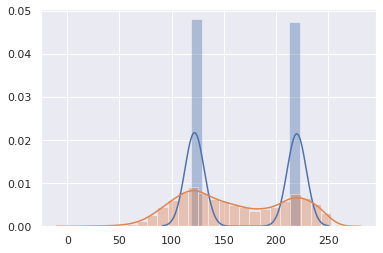

In [19]:
#from pymc3 documentation on gaussian mixture model
k = 2
ndata = n_neg
spread = 3000
centers = np.array([122, 220, 155])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)
_=sns.distplot(data,label='simulated')
_=sns.distplot(X_gr_n_m,label='observed')

In [20]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[120, 220], sd=25, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         )

    # measurement error
    sd_ = pm.Uniform('sd_', lower=20, upper=30)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd_,
                       observed=X_gr_n_m)

In [ ]:
with model:
    step1 = pm.Metropolis(vars=[p, sd_, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1])
    tr = pm.sample(10000, step=[step1, step2], tune=5000)

/home/morgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd_]
>>Metropolis: [p]
>ElemwiseCategorical: [category]
Sampling 4 chains: 100%|██████████| 60000/60000 [27:27<00:00, 36.41draws/s]


In [ ]:
help(pm.ElemwiseCategorical)

In [ ]:
m1,m2,s1,s2=120,220,22,28
#define custom distribution
 

In [ ]:
with pm.Model() as model:
    m1_=pm.Exponential('m1_',m1)
    m2_=pm.Exponential('m2_',m2)
    s1_=pm.Exponential('s1_',s1)
    s2_=pm.Exponential('s2_',s2)
    sim_neg1_=pm.Normal('sim_neg1_',mu=m1_,sd=s1_,observed=X_gr_p_m)
    trace=pm.sample(draws=10000)

In [ ]:
poi_rvs=poisson(lambda_est).rvs(n_pos)

In [ ]:
sns.distplot(X_p_mean,label='observed')
sns.distplot(poi_rvs,label='simulated')

plt.legend(labels=['observed','simulated'])
plt.show()

In [ ]:
#priors for gamma distribution
alpha_est=np.mean(X_p_mean)**2/np.var(X_p_mean)
beta_est=np.var(X_p_mean)/np.mean(X_p_mean)

x=np.linspace(start=0,stop=255,num=n_pos)

prior=gamma.pdf(x,a=alpha_est,scale=1/beta_est)

In [ ]:
with pm.Model() as model:
    lambda_=pm.Gamma('lambda_',alpha=alpha_est,beta=beta_est)
    simulated_positive_=pm.Poisson('simulated_positive_',mu=prior,observed=X_p_mean)
    trace=pm.sample(draws=10000,chains=4)

In [ ]:
lambda_post=trace['lambda_']
ci95_l=np.percentile(lambda_post,[2.5,97.5])

In [ ]:
_=pm.plot_posterior(trace)

In [ ]:
#simulated_positive

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
_=plt.plot(lambda_post)
_=plt.title(r'$\lambda$ line plot')
_=plt.xlabel('iterations')
_=plt.ylabel(r'$\lambda$')

plt.subplot(1,2,1)
_=plt.hist(lambda_post,bins=50,density=True)
_=plt.axvline(ci95_l[0],color='r')
_=plt.axvline(ci95_l[1],color='r')
plt.show()

In [ ]:
_=pm.plots.traceplot(trace)

In [ ]:
poi_post=poisson(np.mean(lambda_post)).rvs(n_pos)

In [ ]:
sns.distplot(X_p_mean,label='observed')
sns.distplot(poi_post,label='simulated')

plt.legend(labels=['observed','simulated'])
plt.show()

In [ ]:
#try the same with grayscale

